# Data Governance Pipeline

This notebook walks through the steps to run and monitor a complete data governance pipeline involving:

- MongoDB 8.0.11
- Hadoop 3.0.0 + HDFS
- Hive 2.3.9
- Great Expectations 1.5.3
- Apache Ranger 2.0
- Apache Atlas (via Docker)
- Apache Airflow 3.5.0

## 1.Generate Synthetic Data

Create synthetic student and course data using `Faker`.

In [ ]:
# Create and activate virtual environment
python3 -m venv ~/venvs/data-gov
source ~/venvs/data-gov/bin/activate

# Install dependencies
pip install --upgrade pip
pip install faker numpy pandas

# Generate data
cd "/PATH_TO_PROJECT"
python data_generator/generate_data.py

You will see files like `students.csv`, `enrollments.csv`,... in the `data/` folder.

## 2.Start MongoDB & Hadoop (Terminal 1)

In [ ]:
# Activate environment
source ~/venvs/data-gov/bin/activate
pip install pymongo pyhive sqlalchemy

# Start MongoDB (Adjust if needed)
/home/myubuntu/mongodb/bin/mongod \
  --dbpath /home/myubuntu/mongodb/data/db \
  --logpath /home/myubuntu/mongodb/log/mongod.log \
  --fork

# Format and start HDFS
hdfs namenode -format
cd ~/hive/bin/
hdfs namenode

You will see log output confirming MongoDB and HDFS started.

## 3.Start HDFS Datanode (Terminal 2)

In [ ]:
source ~/venvs/data-gov/bin/activate
cd ~/hive/bin/
hdfs datanode

You will see log output confirming HDFS started.

## 4.Initialize Hive Metastore (Terminal 3)

In [ ]:
source ~/venvs/data-gov/bin/activate
cd ~/hive/bin/

# Only if metastore doesn't exist
rm -rf metastore_db

schematool -initSchema -dbType derby
hive --service metastore &

You will see logs confirming Hive metastore is running.

## 5.Ingest Data to MongoDB and HDFS (Terminal 4)

In [ ]:
source ~/venvs/data-gov/bin/activate
cd "/PATH_TO_PROJECT"
python pipeline_tasks/ingest_data.py

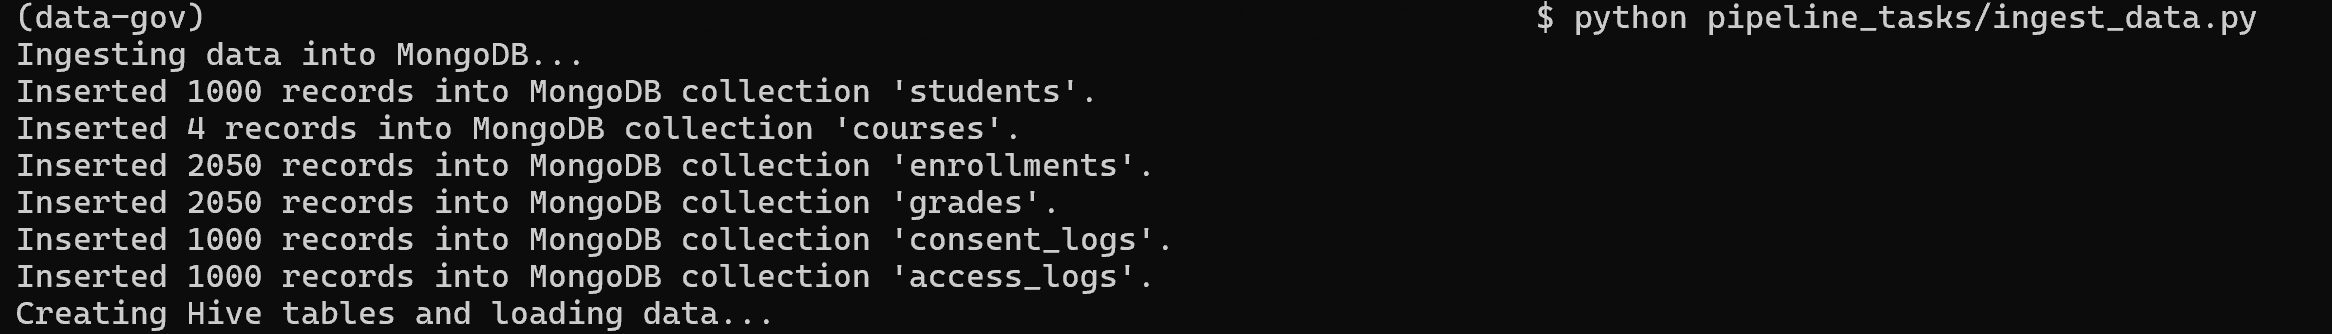

Data loaded to MongoDB and HDFS. Confirm with:

In [ ]:
hdfs dfs -ls /user/hive/warehouse/university_data.db/

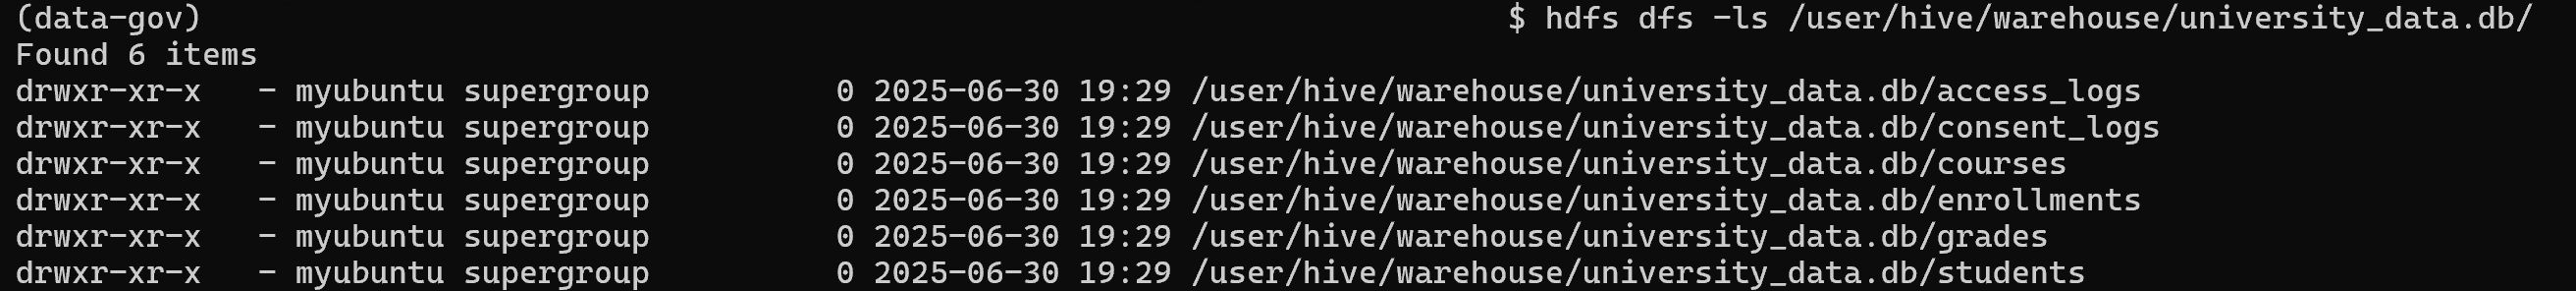

## 6.Load Data into Hive (Terminal 4)

In [ ]:
python pipeline_tasks/load_to_hive.py

Confirm tables:

In [ ]:
hive
USE university_data;
SHOW TABLES;

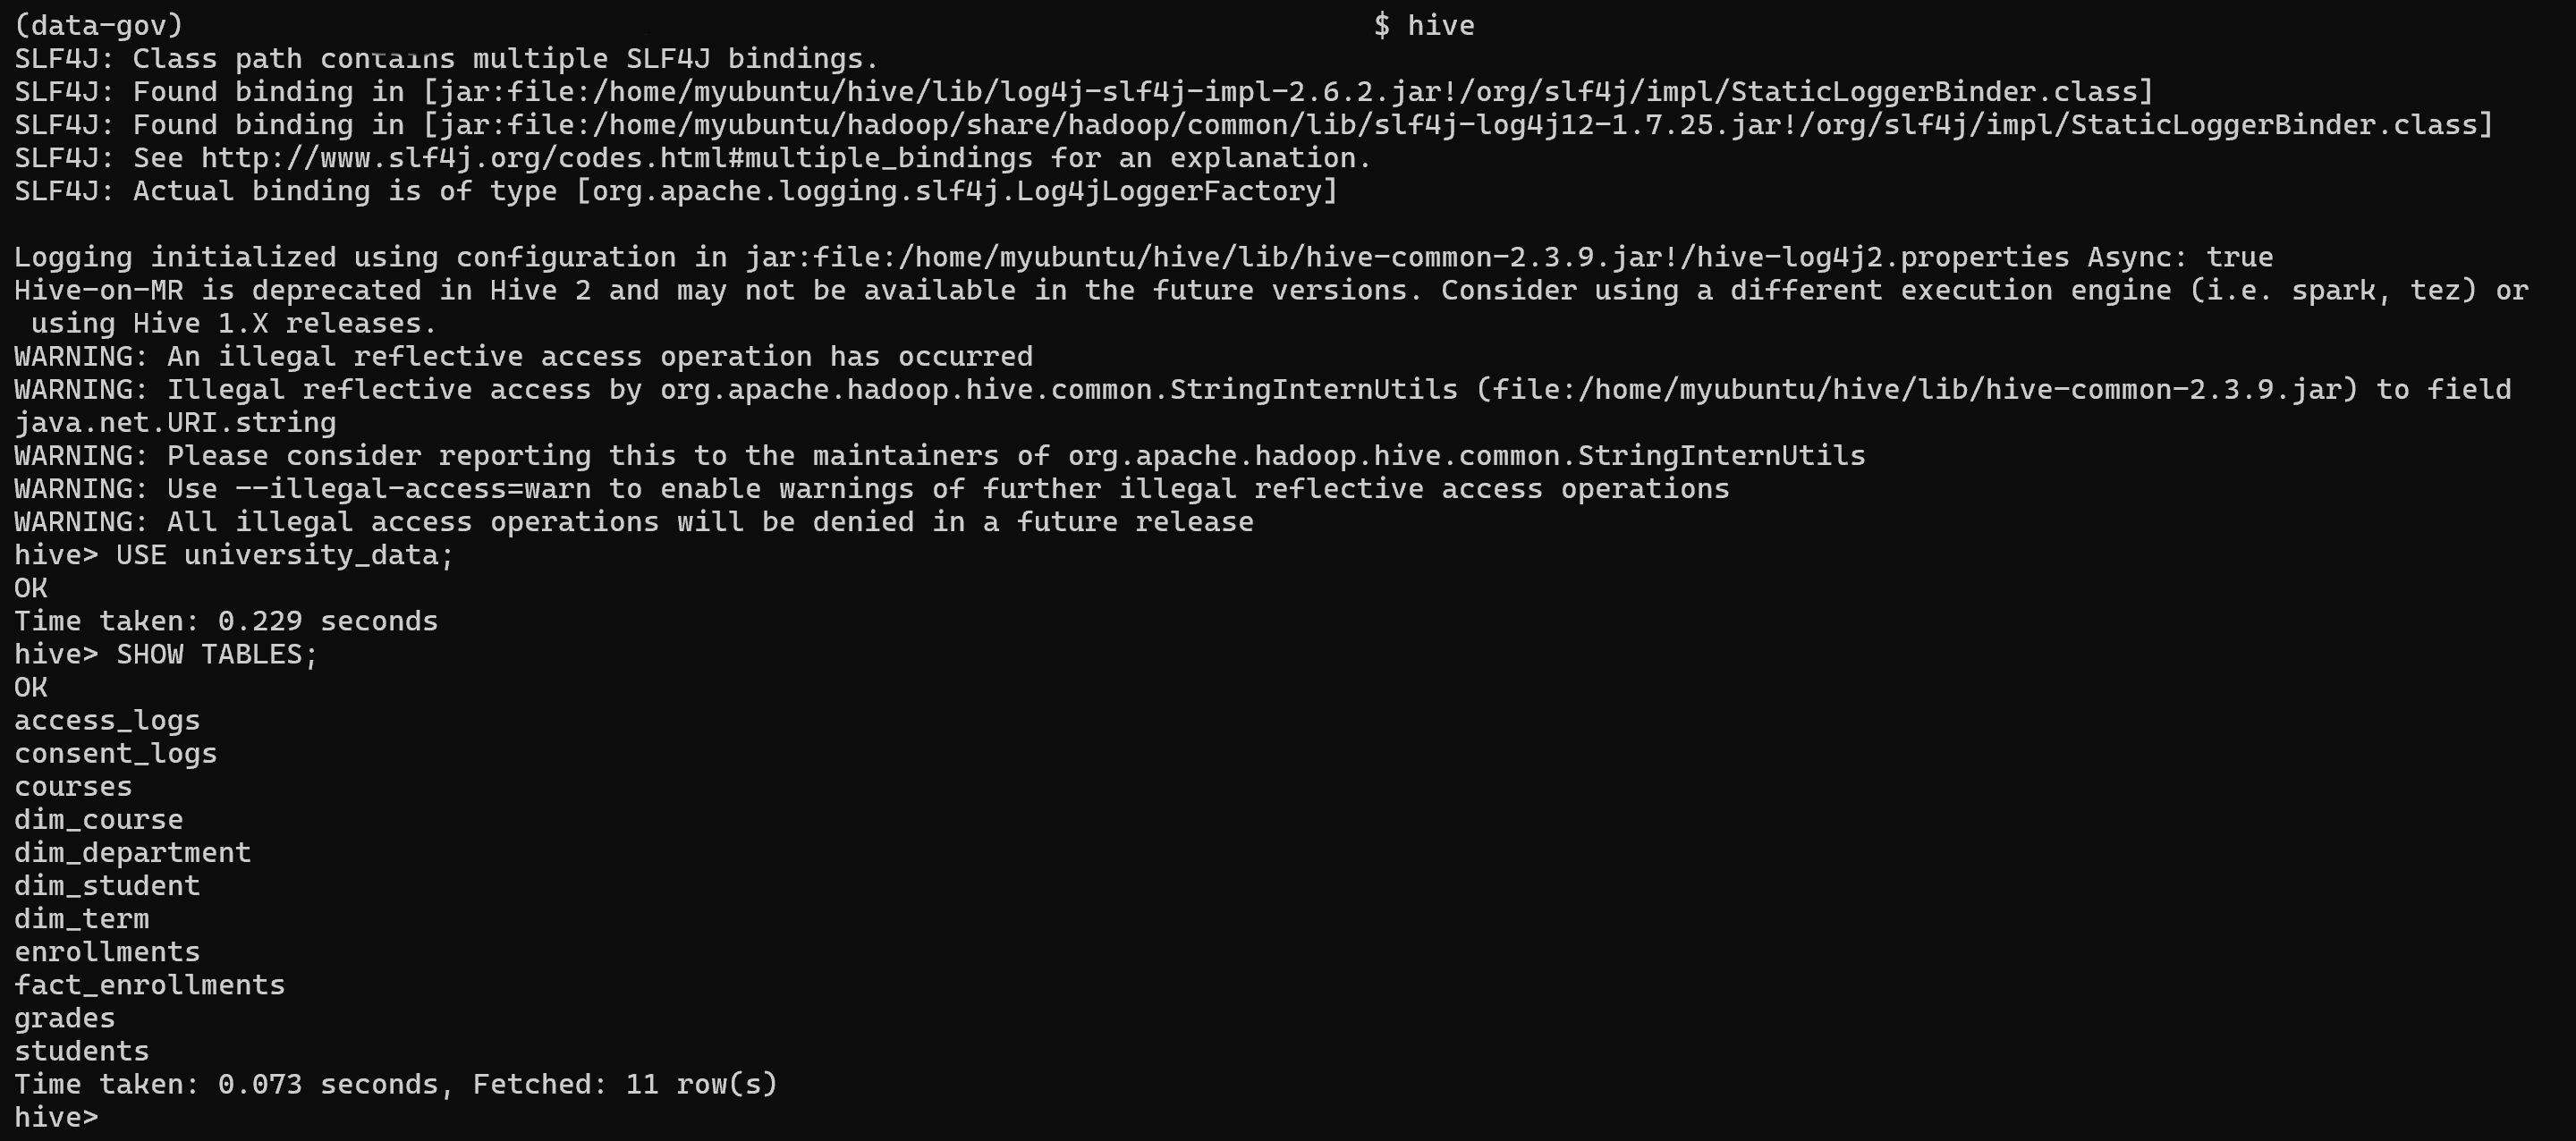

## 7.Run Compliance Monitor (Terminal 4)

In [ ]:
pip install pandas pyhive[sqlalchemy] PyYAML great_expectations
pip install thrift_sasl pure-sasl pexpect

python pipeline_tasks/compliance_monitor.py

The output will show compliance check results:

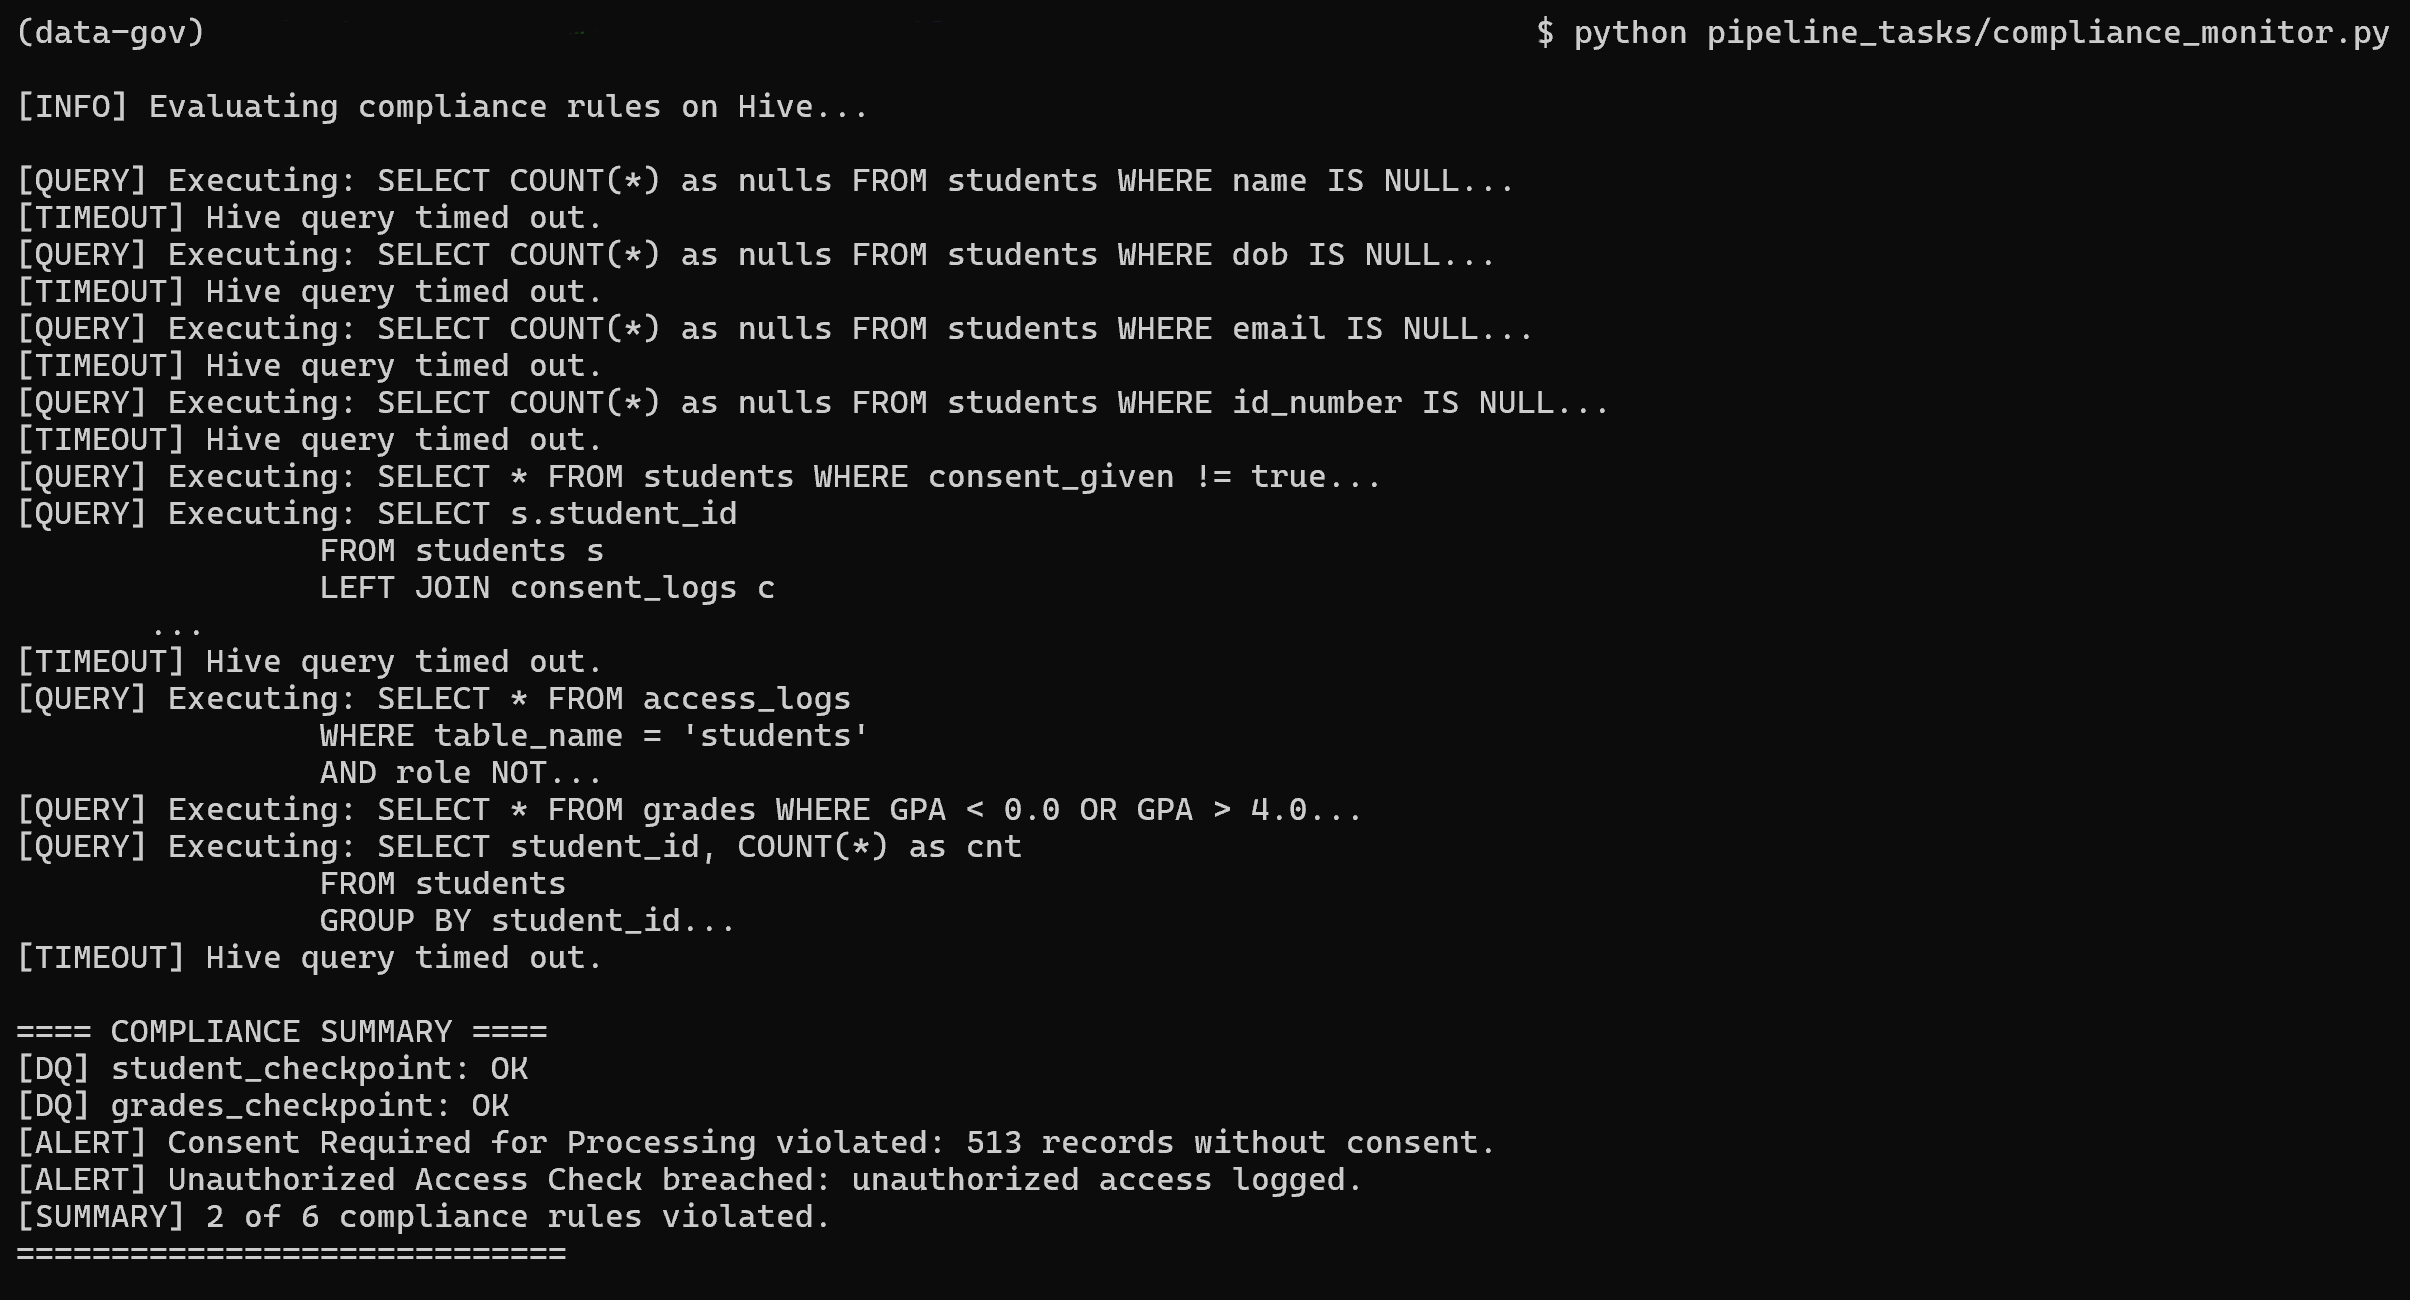

## 8.Update Lineage Metadata in Atlas (Terminal 4+5)

- Terminal 4

In [ ]:
# Start Atlas container
docker stop atlas
docker rm atlas
docker run -d -p 21000:21000 --name atlas sburn/apache-atlas
docker logs -f atlas

- Terminal 5

In [ ]:
# Update lineage metadata
source ~/venvs/data-gov/bin/activate
cd "/PATH_TO_PROJECT"
pip install requests
python atlas_integration/update_lineage_metadata.py

Output: Lineage and entity updates in Apache Atlas

Visit: http://localhost:21000

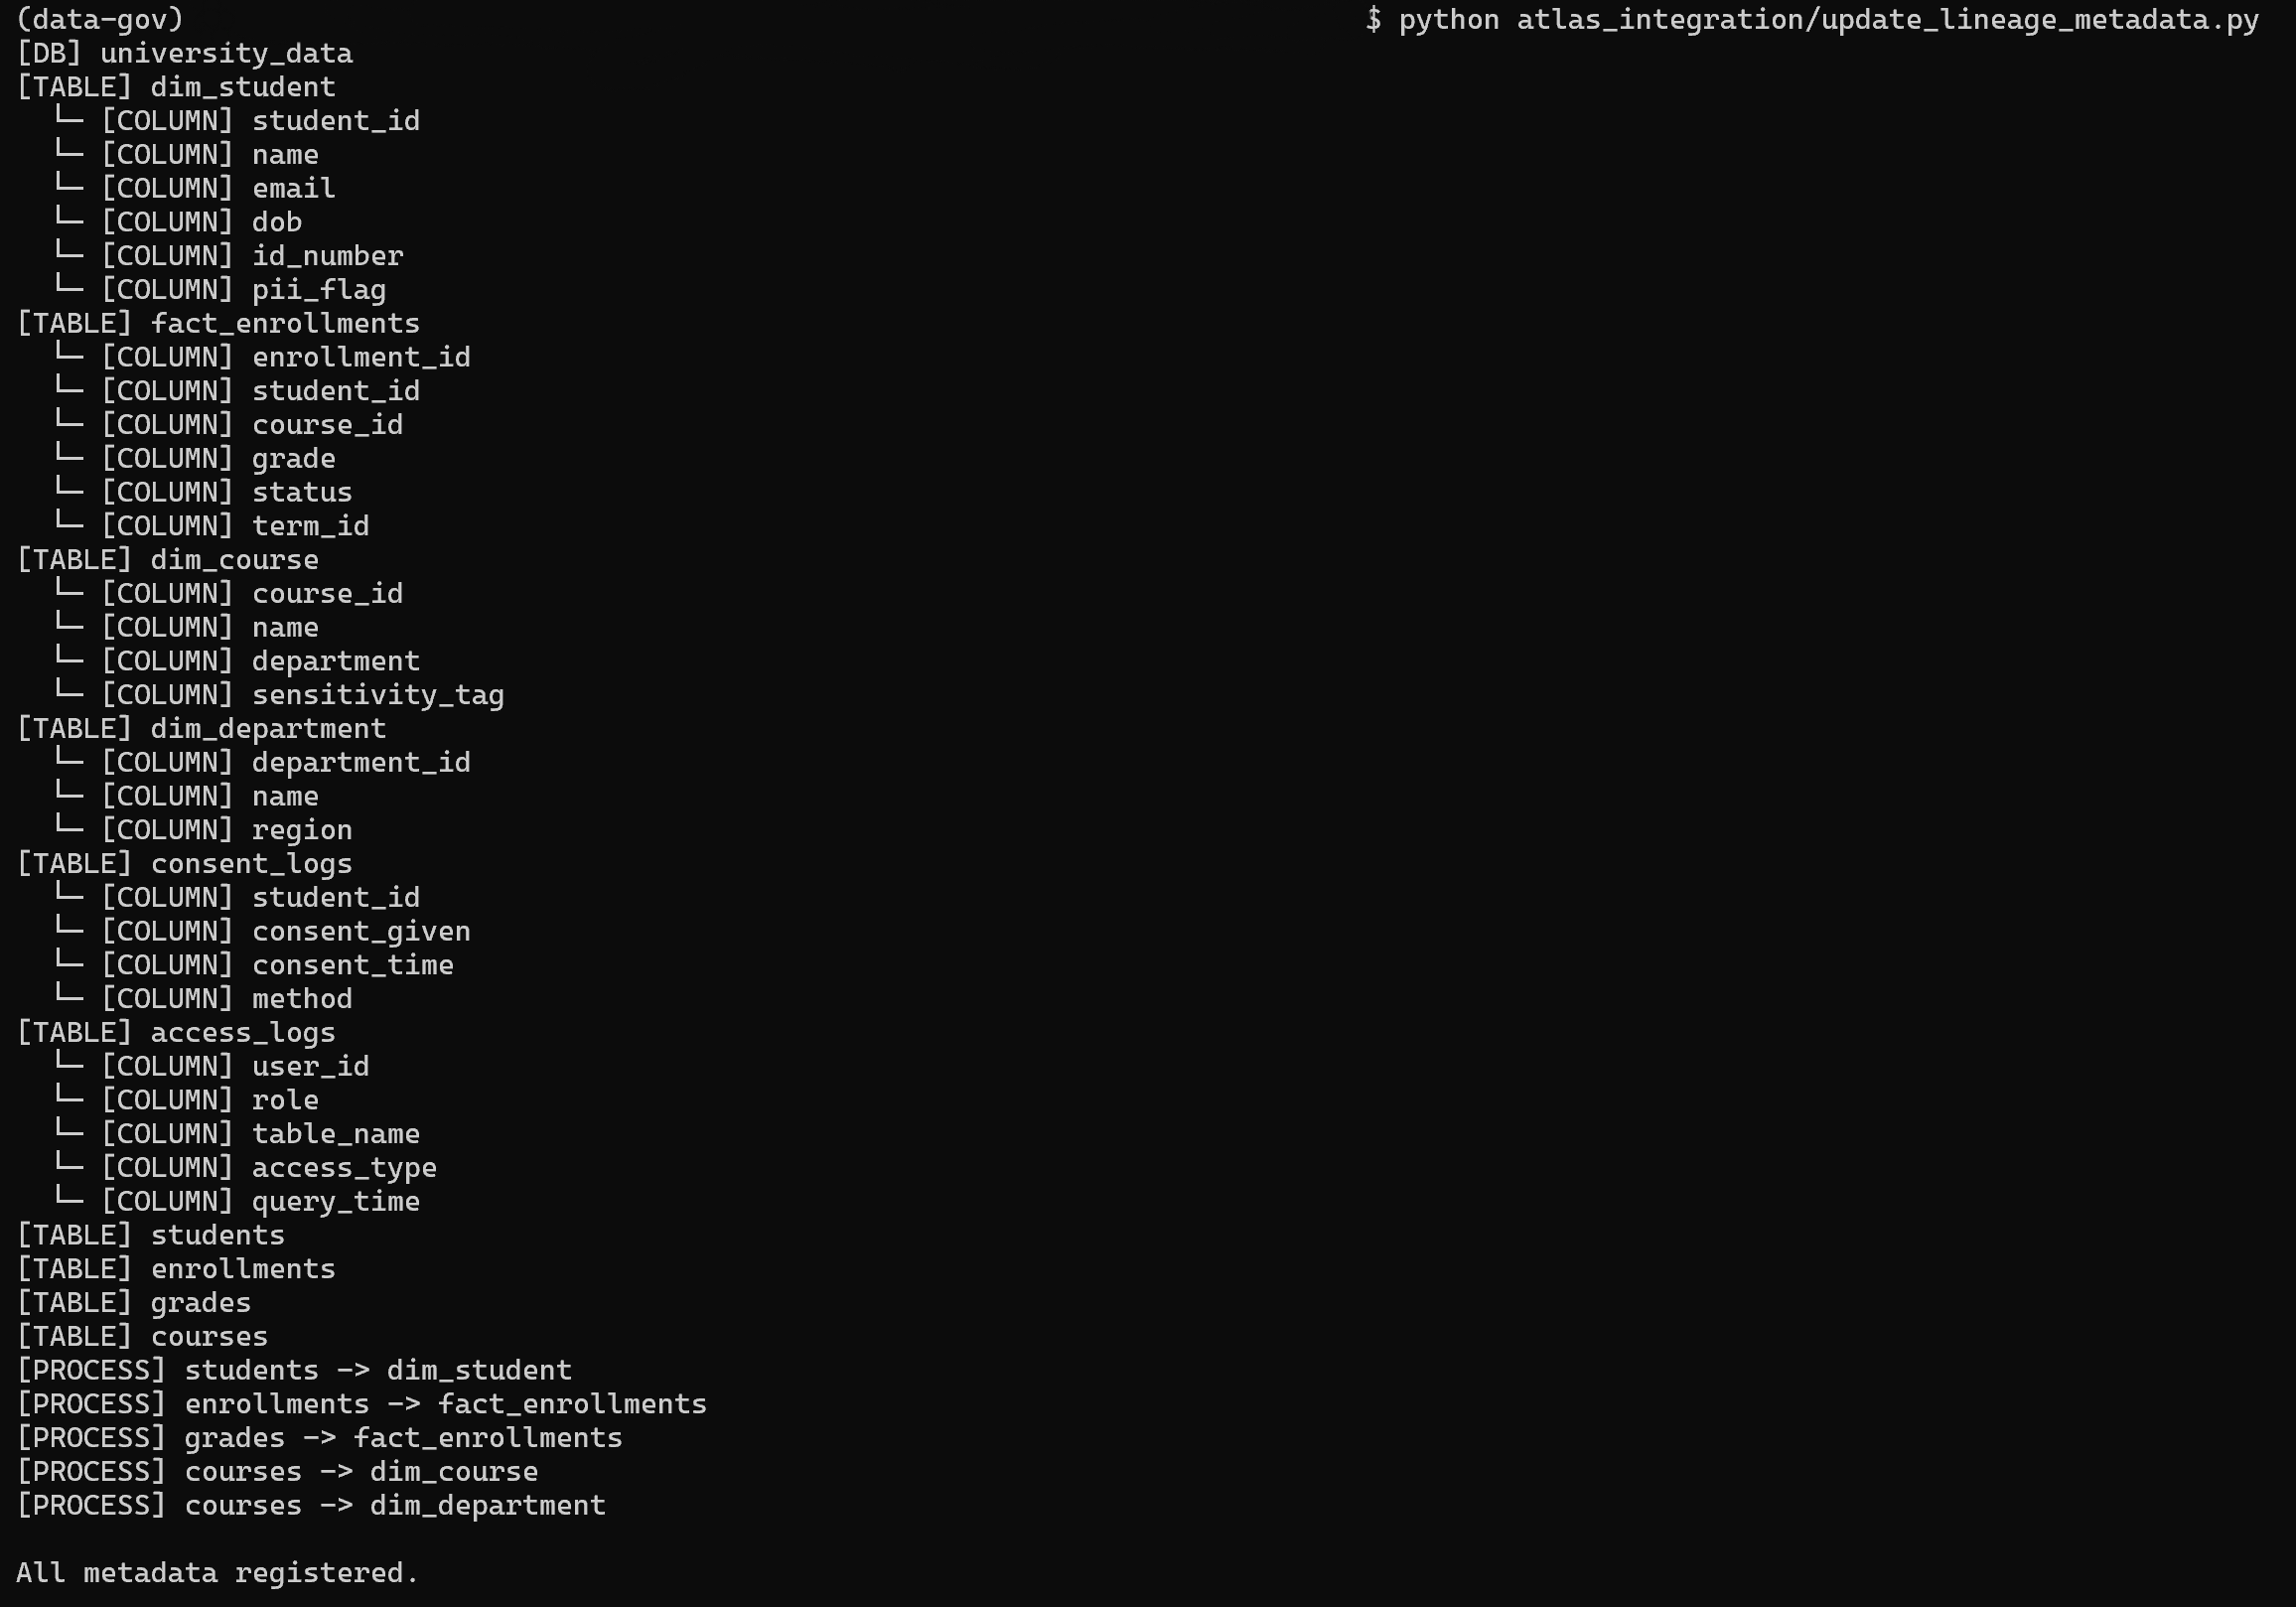

## 9.Launch Streamlit Dashboard (Terminal 5)

In [ ]:
pip install streamlit pandas pyyaml
streamlit run dashboard/streamlit_ui.py

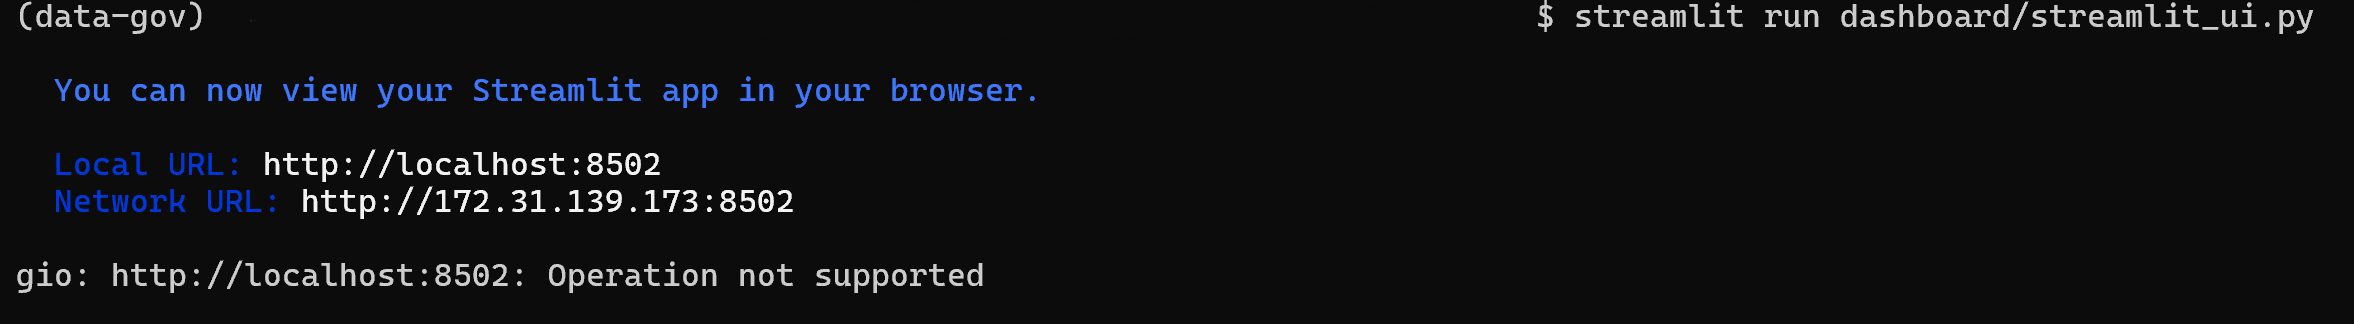

Access: http://localhost:8501

Click “Run Compliance Monitor”

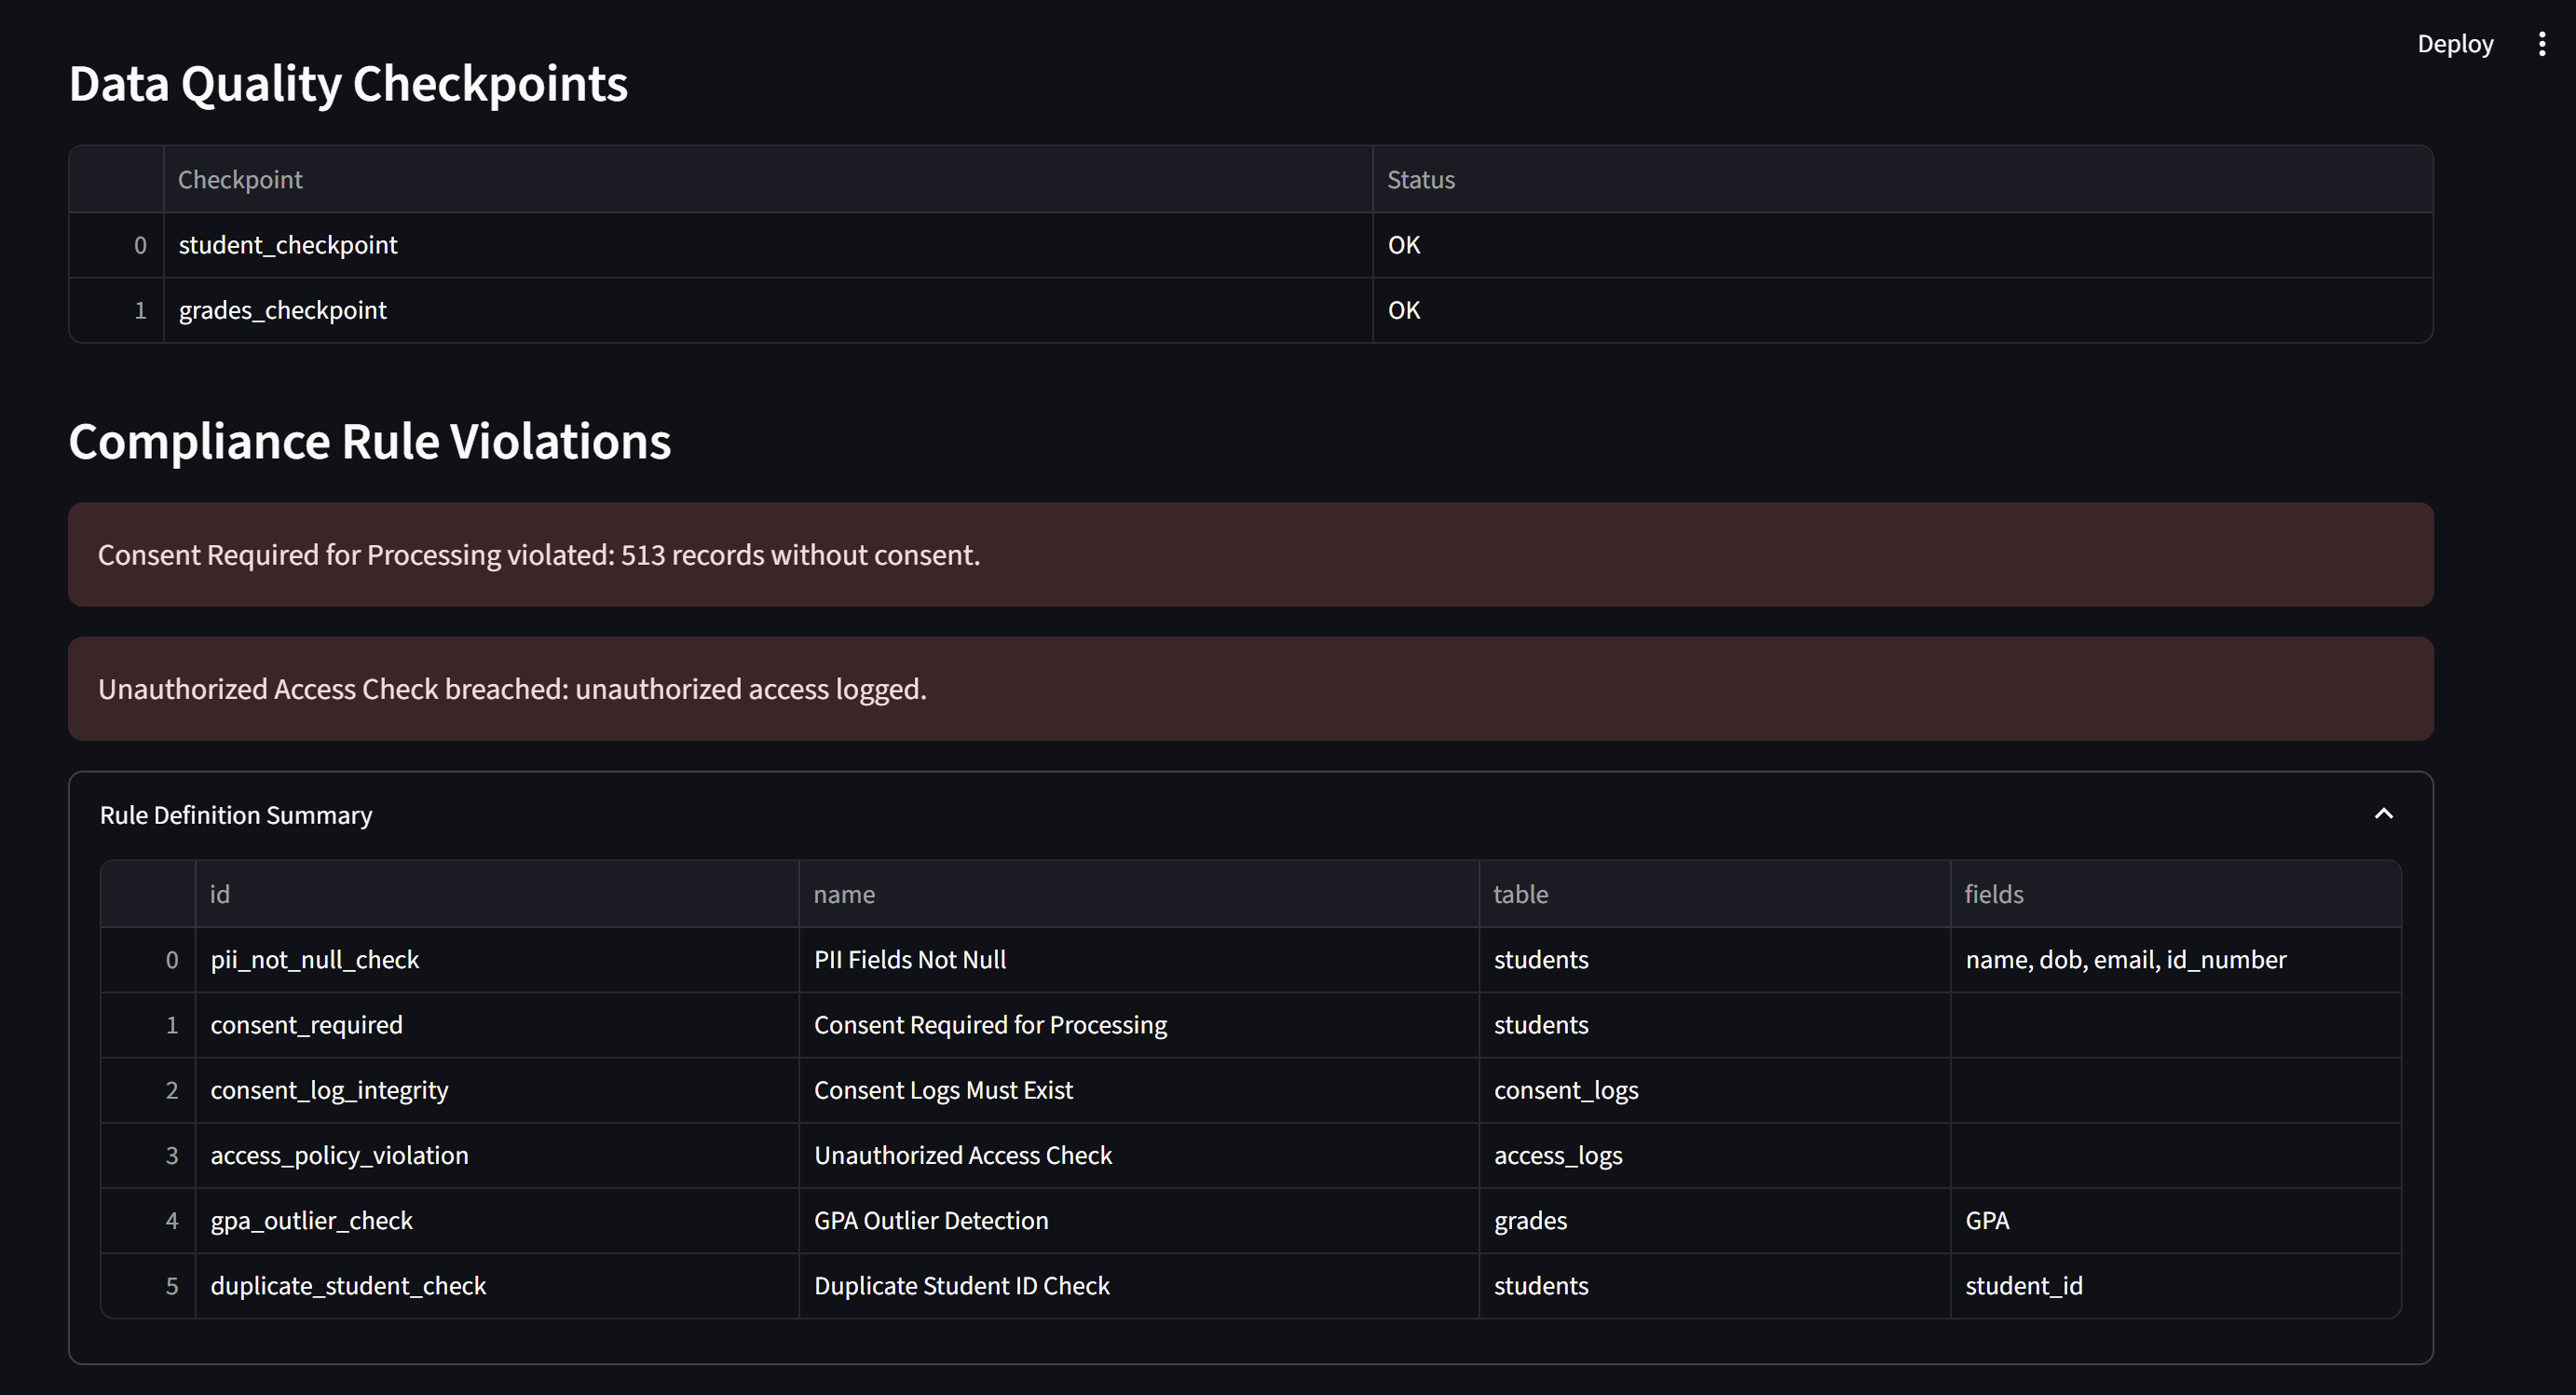

## 10.Orchestrate with Airflow (Terminal 5 & 6)

- Terminal 5

In [ ]:
curl -O https://bootstrap.pypa.io/get-pip.py
python get-pip.py --break-system-packages

pip install alembic==1.13.1
pip install "apache-airflow==3.0.0" --constraint "https://raw.githubusercontent.com/apache/airflow/constraints-3.0.0/constraints-3.10.txt"

# Adjust if needed
export AIRFLOW_HOME=~/airflow_env/airflow_home
export SPARK_LOCAL_IP=127.0.0.1

airflow standalone

- Terminal 6

In [ ]:
source ~/venvs/data-gov/bin/activate
export AIRFLOW_HOME=~/airflow_env/airflow_home
export SPARK_LOCAL_IP=127.0.0.1

airflow dags trigger governance_orchestration
airflow dags unpause governance_orchestration

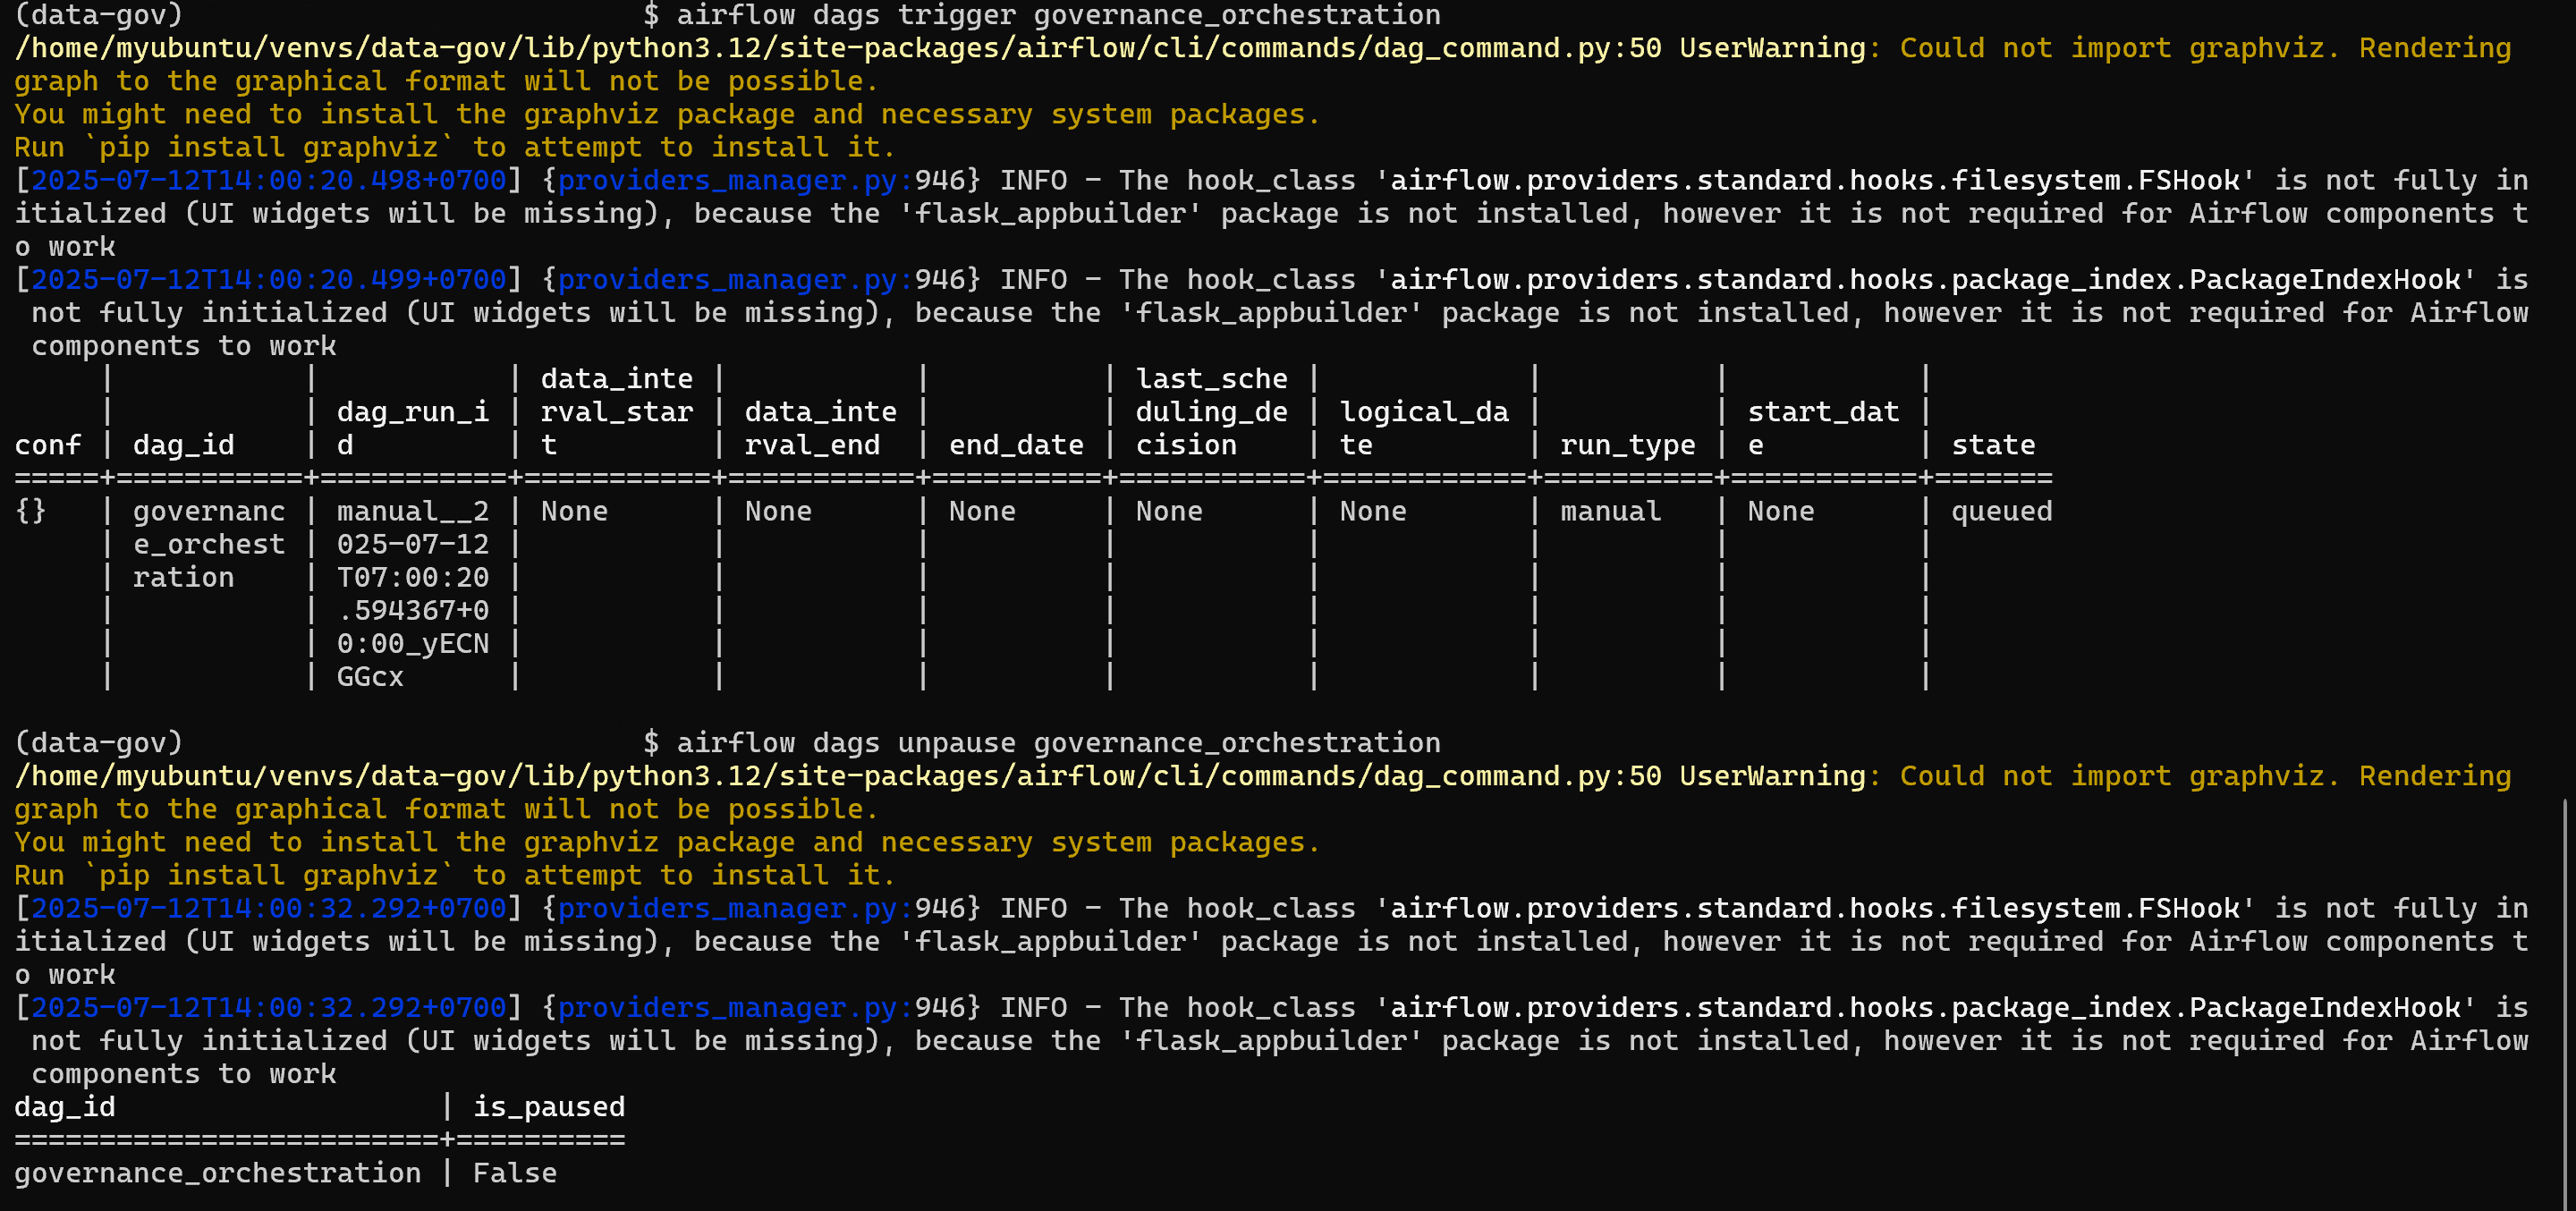

Visit: http://localhost:8080

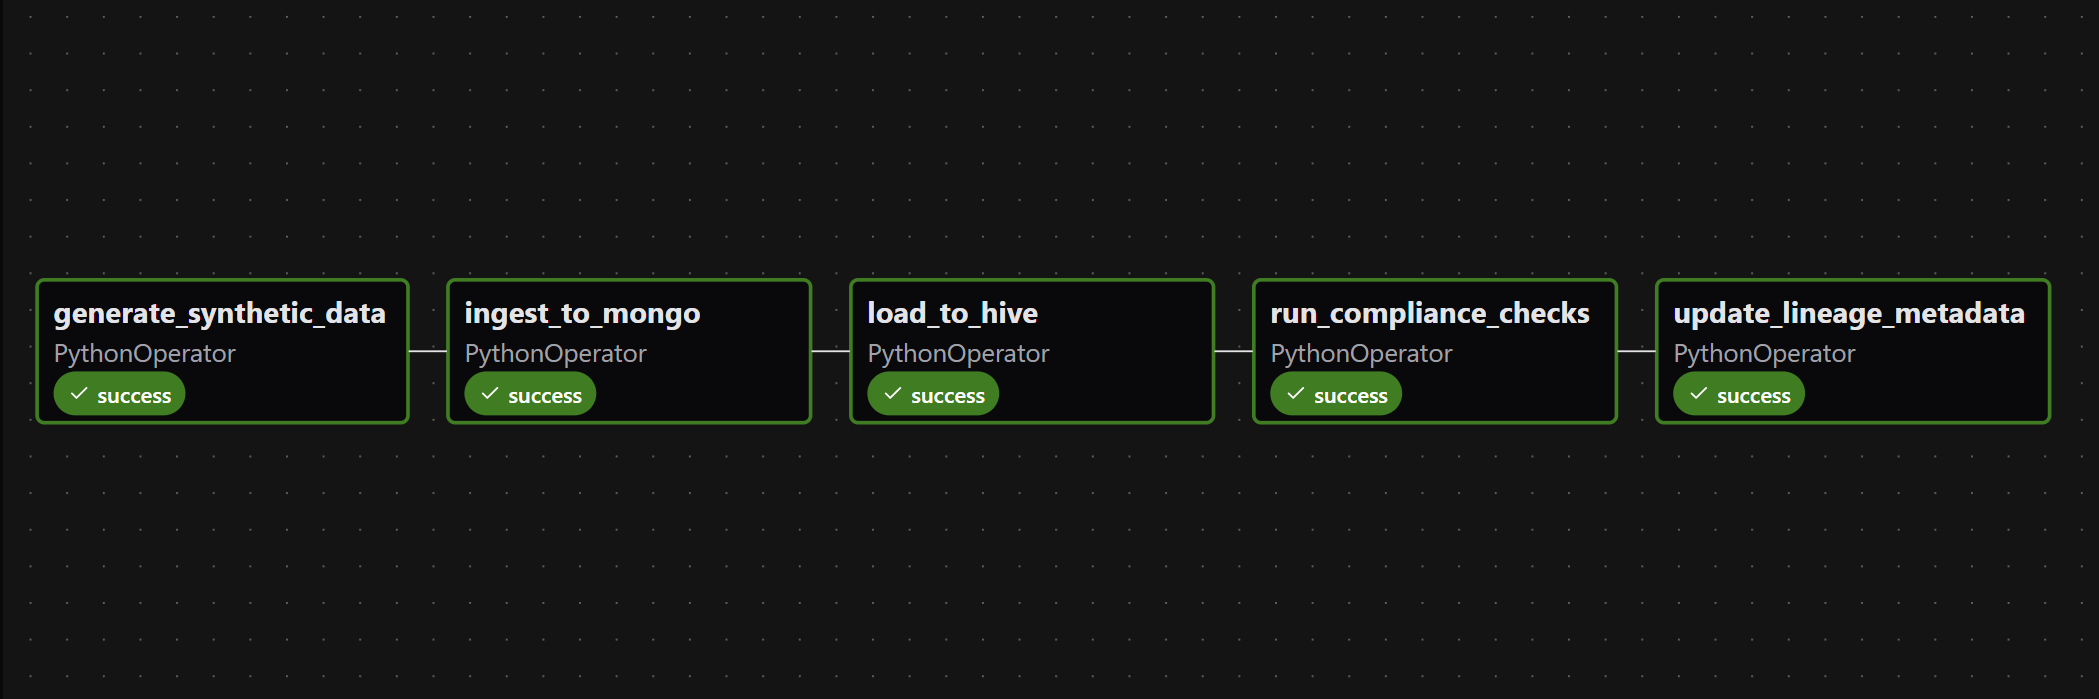

## 11.Notes

### Hive CLI

For this project, I use an earlier version of Hive that supports the legacy Hive CLI (hive -f) instead of HiveServer2 with Beeline. This setup is intentional to simplify integration with Python scripts and shell-based automation during development and testing.

While HiveServer2 and Beeline are recommended for production environments due to their enhanced security and multi-user support, the CLI-based approach is sufficient and efficient for:
Development workflows

- Local testing
- Rapid prototyping
- Script-driven data loading

If needed, this setup can be upgraded to HiveServer2 without major changes to the SQL scripts.


### Execution Summary

Data Quality Checks (Great Expectations):
- student_checkpoint: OK
- grades_checkpoint: OK

Compliance Rule Violations:
- Consent Required for Processing: 513 records without consent.
- Unauthorized Access Check: Detected access by roles not allowed.

Execution Timeouts:
- 4 queries (e.g., IS NULL checks, joins, aggregation) timed out.
- These queries relied on Hive CLI (MapReduce mode), which is slow to initialize for each query — causing repeated TLE (Timeout Limit Exceeded) under subprocess.


> Due to the use of Hive CLI in local MapReduce mode, some compliance queries may exceed execution time limits, especially those involving joins or full table scans. In a production setting, we recommend switching to HiveServer2 with Beeline or a persistent JDBC/Thrift-based client to avoid job spin-up overhead.

### Limitations: Root Causes of Performance Issues


**Hive CLI with MapReduce is slow and inefficient**
- Hive CLI executes each query as a separate MapReduce job, leading to long job startup times and high latency.
- Several compliance queries timed out (e.g., COUNT, JOIN, GROUP BY) due to full-table scans on large datasets.

**Lack of HiveServer2 and Beeline**
- The current setup does not use HiveServer2, which supports persistent connections and better performance for external tools like Great Expectations.
- This prevents the use of `PyHive` or JDBC-based connections that are more stable and performant than subprocess calls.

**Raw tables stored as TEXTFILE**
- Raw tables (`students`, `grades`, etc.) use the inefficient `TEXTFILE` format, causing slow I/O and no predicate pushdown.
- This severely impacts queries with `WHERE`, `JOIN`, or `GROUP BY` clauses.

**Subprocess-based query execution**
- Queries are sent via `subprocess.Popen` to Hive CLI, lacking connection reuse, streaming, or robust error recovery.

**Data Quality (DQ) and Compliance logic are disconnected**
- Great Expectations runs separately from the custom rule engine, leading to duplicated logic and inconsistent validation depth.


### Recommendations: How to Improve


**Switch to HiveServer2 + Beeline or JDBC**
   - Enable HiveServer2 and connect using:
     - `beeline` CLI or
     - Python clients like `PyHive` or `JayDeBeApi`
   - Benefit: Faster, persistent sessions; easier integration with modern tools.

**Convert raw tables to ORC format**
   - Change `STORED AS TEXTFILE` to `STORED AS ORC` for:
     - Columnar storage
     - Predicate pushdown
     - Faster scan and query execution
   - Example:
     ```sql
     CREATE TABLE students_orc STORED AS ORC AS SELECT * FROM students;
     ```

**Use Tez or Spark as the execution engine**
   - Set Hive execution engine to `tez` or `spark` (once properly configured).
   - These engines are much faster than MapReduce for analytical queries.

**Optimize long-running queries**
   - Add `LIMIT` or `FILTER` conditions in rule checks.
   - For example, use:
     ```sql
     SELECT COUNT(*) FROM students WHERE consent_given != true LIMIT 1000;
     ```

**Integrate DQ and Compliance Checks**
   - Convert some YAML rules into Great Expectations validations for consistency.
   - Run all validations through a single engine.
